# Spectral peaks/landmarks in audio fingerprinting   
### George Tzanetakis, University of Victoria

In this notebook, 

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import librosa 
import IPython.display as ipd
import numpy as np 
import scipy.signal as signal
from numpy.lib.stride_tricks import as_strided
import scipy.ndimage.filters as filters



jazz1, srate = librosa.load('jazz1.wav')
jazz1 = jazz1[0:5*srate]
ipd.Audio(jazz1,rate=srate)




In [2]:
noise = np.random.normal(0, 0.1, len(jazz1))
njazz1 = jazz1+noise
ipd.Audio(njazz1,rate=srate)


In [3]:
daisy1, srate = librosa.load('daisy1.wav')
daisy1 = daisy1[0:5*srate]
ipd.Audio(daisy1,rate=srate)

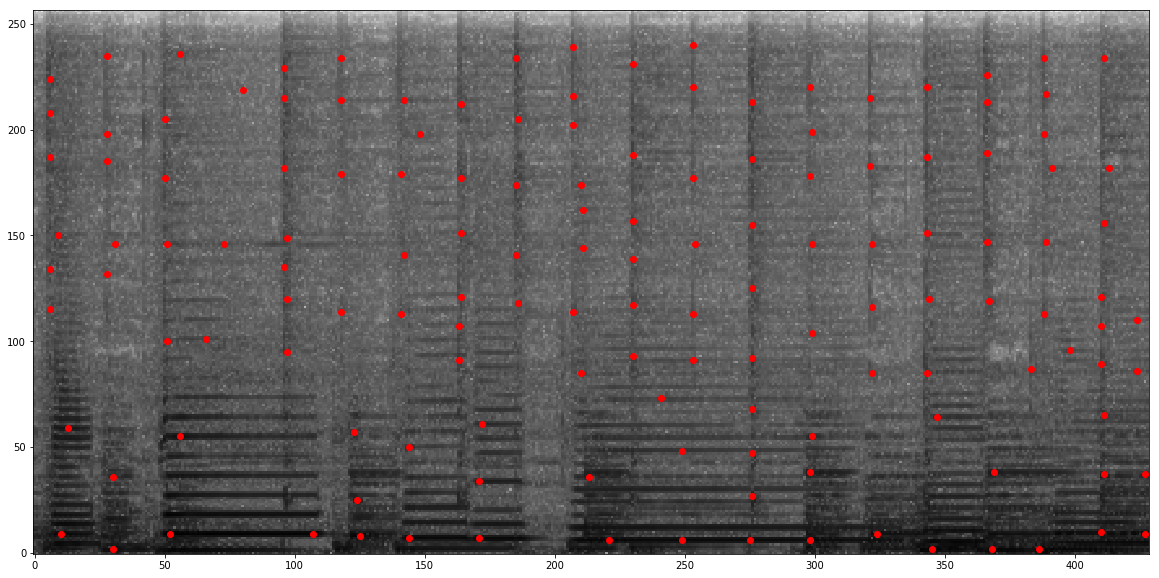

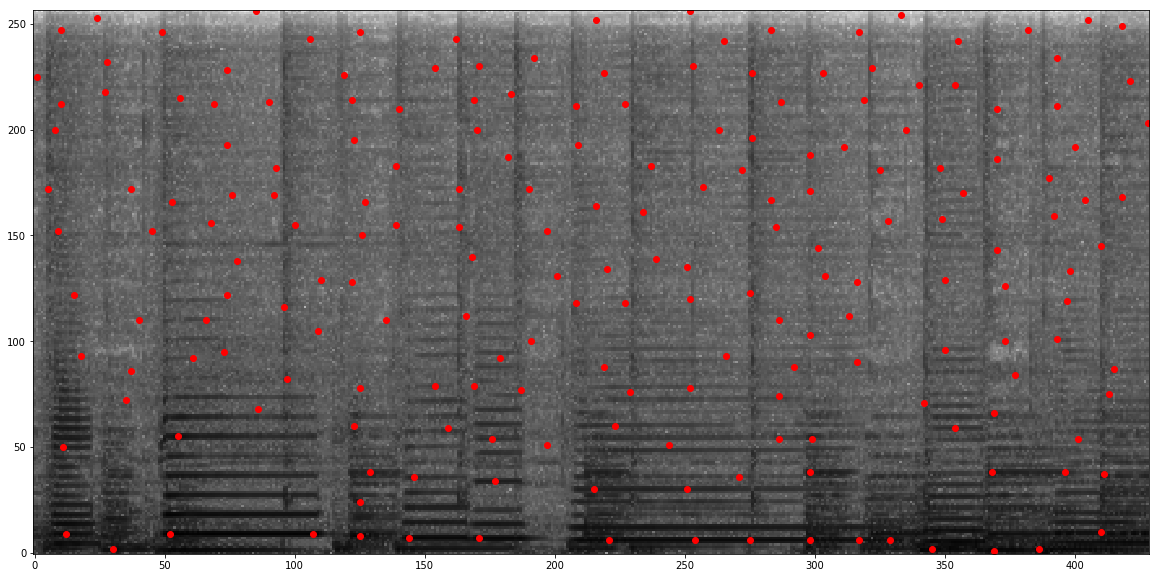

In [4]:
def overlap_window_frames(audio_signal, window, frame_size, hop_size):
    if (len(audio_signal) < frame_size):
        raise Exception('Signal is too short')

    if not audio_signal.flags['C_CONTIGUOUS']:
        raise Exception('Input signal is not contiguous')

    analysis_window = window(frame_size)
    n_frames = 1 + int((len(audio_signal) - frame_size) / hop_size)

    # Vertical stride is one sample
    # Horizontal stride is `hop_size` samples
    audio_frames = as_strided(audio_signal, shape=(frame_size, n_frames),
                          strides=(audio_signal.itemsize, hop_size * audio_signal.itemsize))

    audio_frames = audio_frames * analysis_window[:,None];
    return audio_frames



def spectral_peaks(audio):
    # overlap and window
    audio = np.ascontiguousarray(audio, np.float32)
    audio_frames = overlap_window_frames(audio, signal.hann, 512, 256)

    # perform short time Fourier Transform
    spectrogram = np.fft.rfft(np.transpose(audio_frames))
    db_spectrogram = 20.*np.log10(np.abs(spectrogram)/10e-6+0.000000001) # amplitude to decibel
    local_maxima = filters.maximum_filter(db_spectrogram, 23)
    landmarks = (local_maxima == db_spectrogram)
    [peaks_x,peaks_y] = np.nonzero(landmarks)
    return (db_spectrogram, [peaks_x,peaks_y])


(jazz1_db_spectrogram, [peaks_x,peaks_y]) = spectral_peaks(jazz1)
plt.figure(figsize=(20,10))
plt.imshow(np.transpose(jazz1_db_spectrogram), origin="lower", aspect="auto", cmap='Greys', interpolation="none")
plt.plot(peaks_x, peaks_y, 'ro')
plt.show()

(njazz1_db_spectrogram, [npeaks_x,npeaks_y]) = spectral_peaks(njazz1)
plt.figure(figsize=(20,10))
plt.imshow(np.transpose(jazz1_db_spectrogram), origin="lower", aspect="auto", cmap='Greys', interpolation="none")
plt.plot(npeaks_x, npeaks_y, 'ro')
plt.show()

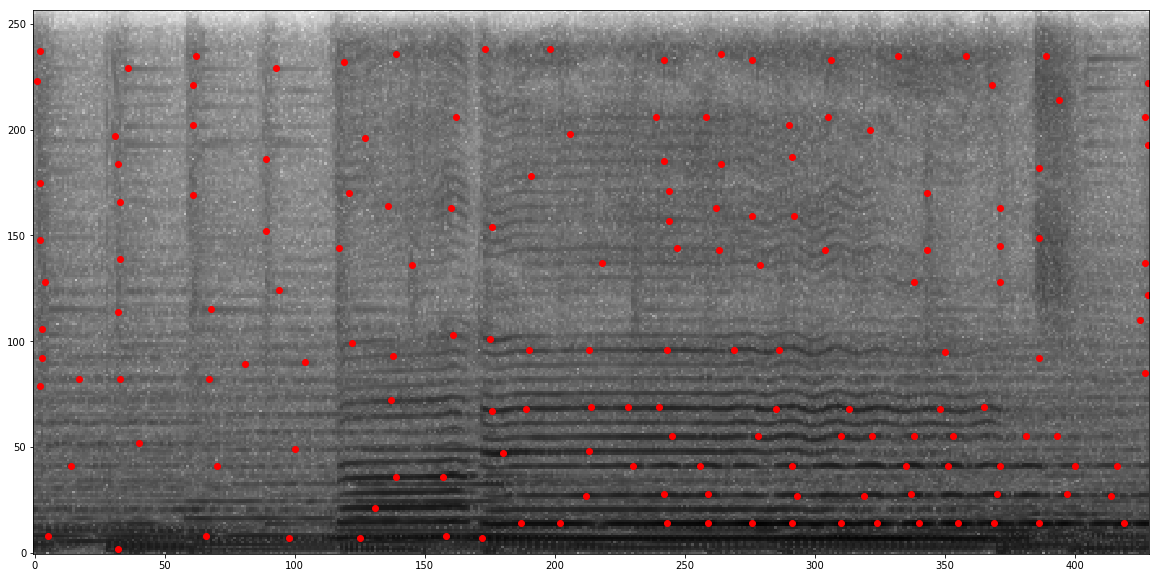

In [5]:
(daisy1_db_spectrogram, [dpeaks_x,dpeaks_y]) = spectral_peaks(daisy1)
plt.figure(figsize=(20,10))
plt.imshow(np.transpose(daisy1_db_spectrogram), origin="lower", aspect="auto", cmap='Greys', interpolation="none")
plt.plot(dpeaks_x, dpeaks_y, 'ro')
plt.show()

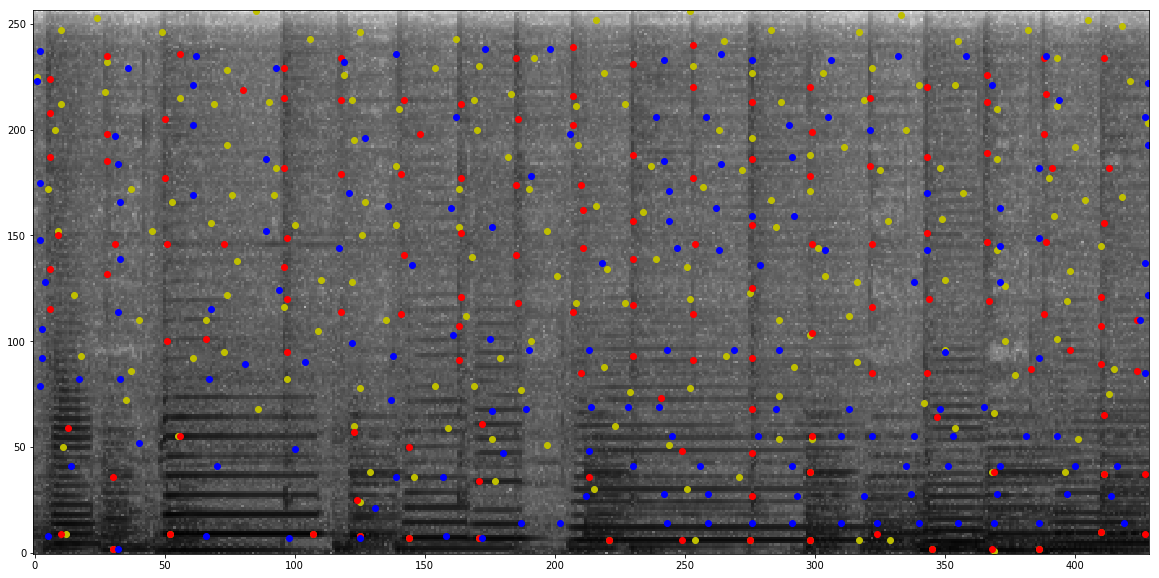

In [6]:
plt.figure(figsize=(20,10))
plt.imshow(np.transpose(jazz1_db_spectrogram), origin="lower", aspect="auto", cmap='Greys', interpolation="none")
plt.plot(npeaks_x, npeaks_y, 'yo')
plt.plot(peaks_x, peaks_y, 'ro')
plt.plot(dpeaks_x, dpeaks_y, 'bo')
plt.show()

In [7]:
# just use the abs difference of the frequencies as the hash - typically several aspects 
# such as the absolute frequency of the two peaks and their time difference are also 
# incorporated into the hash with different quantizations 

def peaks2hashes(peaks_x, peaks_y):
    hashes = []
    k = 0
    for i in range(len(peaks_x)):
        for j in range(1, 3):
            if (i + j) < len(peaks_x):
                freq1 = peaks_y[i]
                freq2 = peaks_y[i + j]
                hashvalue = np.abs(freq2-freq1)
                hashes.append(str(hashvalue))
                k = k + 1
    return hashes

In [8]:
from datasketch import MinHash


hashes = peaks2hashes(peaks_x, peaks_y)
print(len(hashes))
print('Jazz 1 hashes', hashes[0:10])
nhashes = peaks2hashes(npeaks_x, npeaks_y)
print(len(nhashes))
print('Noisy Jazz 1 hashes', nhashes[0:10])
dhashes = peaks2hashes(dpeaks_x, dpeaks_y)
print(len(dhashes))
print('Daisy hashes', dhashes[0:10])

287
Jazz 1 hashes ['19', '72', '53', '74', '21', '37', '16', '58', '74', '215']
391
Noisy Jazz 1 hashes ['53', '25', '28', '20', '48', '12', '60', '95', '35', '162']
315
Daisy hashes ['144', '75', '69', '96', '27', '89', '62', '83', '145', '131']


In [9]:
s1 = set(hashes)
s2 = set(nhashes)
s3 = set(dhashes)

In [10]:
# Calculate actual jaccard similarities by counting the number of common integers in the
# hashes of the pair of recordings considered 

actual_jaccard = float(len(s1.intersection(s1))) / float(len(s1.union(s1)))
print("Actual Jaccard for data1 and data1 is", actual_jaccard)
actual_jaccard = float(len(s1.intersection(s2))) / float(len(s1.union(s2)))
print("Actual Jaccard for data1 and data2 is", actual_jaccard)
actual_jaccard = float(len(s1.intersection(s3))) / float(len(s1.union(s3)))
print("Actual Jaccard for data1 and data3 is", actual_jaccard)

  

Actual Jaccard for data1 and data1 is 1.0
Actual Jaccard for data1 and data2 is 0.5458937198067633
Actual Jaccard for data1 and data3 is 0.4816753926701571


In [11]:
# Approximate jaccard using min-hash 

m1, m2, m3 = MinHash(num_perm=20), MinHash(num_perm=20), MinHash(num_perm=20)
for d in hashes:
    m1.update(d.encode('utf8'))
for d in nhashes:
    m2.update(d.encode('utf8'))
for d in dhashes:
    m3.update(d.encode('utf8'))


print("Estimated Jaccard for data1 and data1 is", m1.jaccard(m1))
print("Estimated Jaccard for data1 and data2 is", m1.jaccard(m2))
print("Estimated Jaccard for data1 and data2 is", m1.jaccard(m3))



Estimated Jaccard for data1 and data1 is 1.0
Estimated Jaccard for data1 and data2 is 0.4
Estimated Jaccard for data1 and data2 is 0.35
